In [23]:
import os
import itertools
import pandas as pd
import numpy as np
from Bio import SeqIO, SeqUtils, Seq, Alphabet
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns; sns.set_palette("Dark2"); sns.set(font_scale=1.5); sns.set_style("ticks")
from scipy import signal, fftpack, stats
import random; random.seed(2091994)

In [24]:
def autocorr_dinucs(
    sequence,
    autocorr_distance,
    dinucs=['AA','AC','AT','AG','CA','CC','CT','CG','TA','TC','TT','TG','GA','GC','GT','GG'],
    smoothing=False,
    subtract_bg=False):
    
    
    autocorrelation = {}
    for dinuc in dinucs:
        autocorrelation[dinuc] = [0]*autocorr_distance
        for pos in range(len(sequence)-autocorr_distance):
            if sequence[pos:pos+2] == dinuc:
                for count in range(0, autocorr_distance):
                    new_pos = pos + count
                    if sequence[new_pos:new_pos+2] == dinuc:
                        autocorrelation[dinuc][count] += 1
                        
    if smoothing:
        
        autocorrelation_smooth = {}
        
        # smooth the autocorrelation by a 3bp window
        for dinuc in autocorrelation:
            new_list = [0] * len(autocorrelation[dinuc])
            for i, entry in enumerate(autocorrelation[dinuc]):
                if (i+3) <= len(autocorrelation[dinuc]):
                    middle_of_window = i+1
                    new_list[middle_of_window] = np.mean(autocorrelation[dinuc][i:i+3]) 
            autocorrelation_smooth[dinuc] = new_list
        
        
    if subtract_bg:
        
        autocorrelation_bgsub = {}
        
        # calculate the bg of 11bp and subtract it from the autocorrelation
        for dinuc in autocorrelation_smooth:
            bg = [0] * len(autocorrelation_smooth[dinuc])
            for i, entry in enumerate(autocorrelation_smooth[dinuc]):
                if (i+11) <= len(autocorrelation_smooth[dinuc]):
                    middle_of_window = i + (11//2)
                    bg[middle_of_window] = np.mean(autocorrelation_smooth[dinuc][i:i+11]) 
            autocorrelation_bgsub[dinuc] = [a_i - b_i for a_i, b_i in zip(autocorrelation_smooth[dinuc], bg)]
        
    
    if not smoothing and not subtract_bg:
        return(autocorrelation)
    elif smoothing and not subtract_bg:
        return(autocorrelation, autocorrelation_smooth)
    elif smoothing and subtract_bg:
            return(autocorrelation, autocorrelation_smooth, autocorrelation_bgsub)

In [25]:
def autocorr_dinuc_groups(sequence,
                          autocorr_range = 150,
                          dinuc_group=['AT', 'GC'],
                          smoothing=True,
                          smoothing_range=3,
                          subtract_bg=True,
                          bg_range=11):
    """
    Calculcates autocorrelations in groups of dinucleotides.
    E.g. dinuc_group AT is interpreted as A/T which is AA, TT, AT, TA.
    """
    
    if subtract_bg:
        if not smoothing:
            return(print("Smooth needs to be true if bgsub is true"))
    
    
    autocorrelation = {}
    autocorrelation_smooth = {}
    autocorrelation_bgsub = {}
    for dg in dinuc_group:
    
        dinucs = []
        combinations = itertools.product(dg, repeat=2)
        for i in combinations:
            dinucs.append(i[0]+i[1])
    
        autocorrelation[dg] = [0]*autocorr_range
        for pos in range(len(sequence)-autocorr_range):
            if sequence[pos:pos+2] in dinucs:
                for count in range(0, autocorr_range):
                    new_pos = pos + count
                    if sequence[new_pos:new_pos+2] in dinucs:
                        autocorrelation[dg][count] += 1


        if smoothing:

            # smooth the autocorrelation by a 3bp window
            for dinuc in autocorrelation:
                new_list = [0] * len(autocorrelation[dg])
                for i, entry in enumerate(autocorrelation[dg]):
                    if (i+smoothing_range) <= len(autocorrelation[dg]):
                        middle_of_window = i + (smoothing_range//2)
                        new_list[middle_of_window] = np.mean(autocorrelation[dg][i:i+smoothing_range]) 
                autocorrelation_smooth[dg] = new_list


        if subtract_bg:

            # calculate the bg of 11bp and subtract it from the autocorrelation
            for dinuc in autocorrelation_smooth:
                bg = [0] * len(autocorrelation_smooth[dg])
                for i, entry in enumerate(autocorrelation_smooth[dg]):
                    if (i+bg_range) <= len(autocorrelation_smooth[dg]):
                        middle_of_window = i + (bg_range//2)
                        bg[middle_of_window] = np.mean(autocorrelation_smooth[dg][i:i+bg_range]) 
                autocorrelation_bgsub[dg] = [a_i - b_i for a_i, b_i in zip(autocorrelation_smooth[dg], bg)]
    
    if subtract_bg:
        return(autocorrelation, autocorrelation_smooth, autocorrelation_bgsub)
    elif smoothing:
        return(autocorrelation, autocorrelation_smooth)
    else:
        return(autocorrelation)

In [38]:
# load ad_c5
genome_adc5 = SeqIO.read("../sequences/Ad_E3del_seq/AdVir_del.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load ad_b3
genome_adb3 = SeqIO.read("../sequences/HAd_B3/had_b3.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load ad_b7
genome_adb7 = SeqIO.read("../sequences/HAd_B7/had_b7.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load ad_d26
genome_add26 = SeqIO.read("../sequences/HAd_D26/had_d26.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load ad_f41
genome_adf41 = SeqIO.read("../sequences/HAd_F41/had_f41.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load bat adenovirus 2
genome_bad_2 = SeqIO.read("../sequences/BAd_2/BAd_2.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load variola
genome_variola = SeqIO.read("../sequences/variola/variola.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

# load sv40
genome_sv40 = SeqIO.read("../sequences/sv40/sv40.fa", "fasta", Alphabet.NucleotideAlphabet()).seq

In [39]:
genomes = {
    "HAd C5": genome_adc5,
    "HAd B7": genome_adb7,
    "HAd B3": genome_adb3,
    "HAd D26": genome_add26,
    "HAd F41": genome_adf41,
    "Bat 2" : genome_bad_2,
    "SV40": genome_sv40,
    "Variola": genome_variola
}

In [40]:
pal = sns.color_palette("Dark2")
palette = pal.as_hex()
dinuc_palette = {
    "T/C":palette[0],
    "A/G":palette[1],
    "G/C":palette[2],
    "A/T":palette[3]}

In [41]:
autocorr_range = 150
dinuc_names = ["A/T", "G/C"]
dinucs = ["AT", "GC"]

df = pd.DataFrame()

for genome in genomes:

    auto, smooth, bgsub = autocorr_dinuc_groups(
        genomes[genome],
        autocorr_range=autocorr_range,
        dinuc_group=dinucs,
        bg_range=5)

    temp_df = pd.DataFrame(bgsub)
    
    # normalize by sum
    temp_df = temp_df/temp_df.sum()
    
    temp_df.columns = dinuc_names
    temp_df["dist"] = temp_df.reset_index()["index"]
    temp_df = temp_df.melt(id_vars=["dist"])
    temp_df["genome"] = genome
    temp_df["congregated_category"] = temp_df["variable"] + " " + temp_df["genome"]


    df = df.append(temp_df)

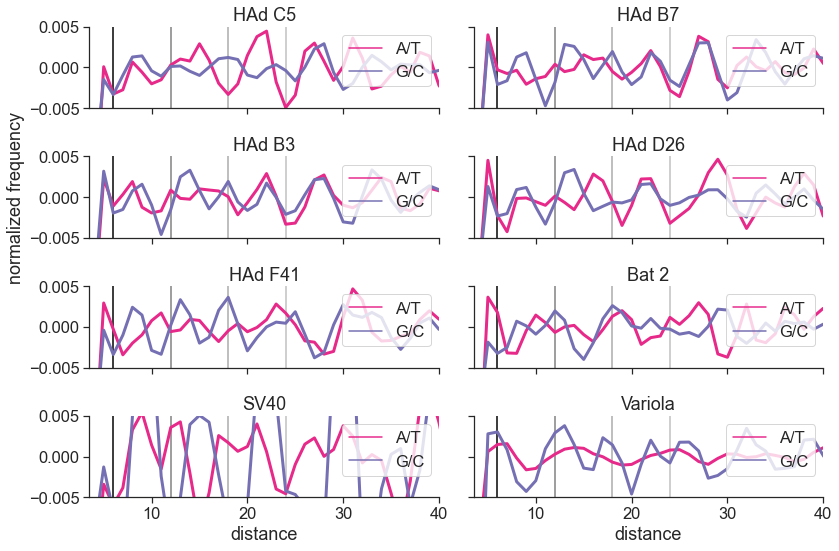

In [42]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8), sharex= True, sharey=True)
row = 0
col = 0
for i, genome in enumerate(df.genome.unique()):
    
    ax[row, col].set_xlim(3.5, 40)
    ax[row, col].set_ylim(-0.005, 0.005)
    
    linespace = 6
    number_lines = 4
    for j in range(number_lines):
        ax[row, col].axvline((j+1)*linespace, color="black", alpha=1/(j+1))
    
    plot_df = df.loc[df["genome"] == genome,]
    
    sns.lineplot(
        x="dist",
        y="value",
        hue="variable",
        data=plot_df,
        ax = ax[row, col],
        legend = True,
        linewidth=3,
        palette=dinuc_palette
    )
    ax[row, col].set_title(genome)
    
    ax[row, col].legend(loc="upper right")
    
    if row == 1:
        ax[row, col].set_ylabel("normalized frequency")
    else:
        ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel("distance")
    
    col += 1
    if col == 2:
        col = 0
        row += 1

sns.despine()
plt.tight_layout()
for ext in [".png", ".svg"]:
    fig.savefig("dinucleotide_autocorr_different_adenoviruses_AT_GC_2"+ext, dpi=300, facecolor="w", transparent=False, bbox_inches="tight")

In [43]:
autocorr_range = 150
dinuc_names = ["T/C", "A/G"]
dinucs = ["TC", "AG"]

df = pd.DataFrame()

for genome in genomes:

    auto, smooth, bgsub = autocorr_dinuc_groups(
        genomes[genome],
        autocorr_range=autocorr_range,
        dinuc_group=dinucs,
        bg_range=5)

    temp_df = pd.DataFrame(bgsub)
    
    # normalize by sum
    temp_df = temp_df/temp_df.sum()
    
    temp_df.columns = dinuc_names
    temp_df["dist"] = temp_df.reset_index()["index"]
    temp_df = temp_df.melt(id_vars=["dist"])
    temp_df["genome"] = genome
    temp_df["congregated_category"] = temp_df["variable"] + " " + temp_df["genome"]


    df = df.append(temp_df)

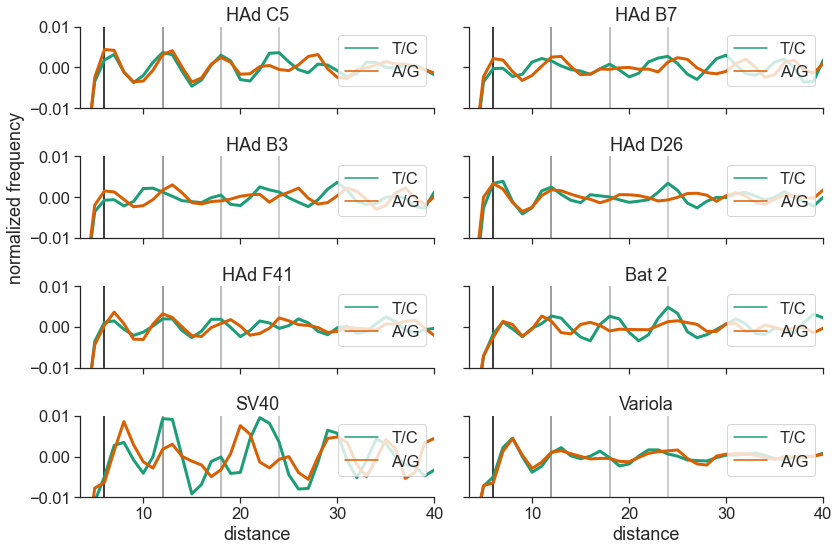

In [45]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8), sharex= True, sharey=True)
row = 0
col = 0
for i, genome in enumerate(df.genome.unique()):
    
    ax[row, col].set_xlim(3.5, 40)
    ax[row, col].set_ylim(-0.01, 0.01)
    
    linespace = 6
    number_lines = 4
    for j in range(number_lines):
        ax[row, col].axvline((j+1)*linespace, color="black", alpha=1/(j+1))
    
    plot_df = df.loc[df["genome"] == genome,]
    
    sns.lineplot(
        x="dist",
        y="value",
        hue="variable",
        data=plot_df,
        ax = ax[row, col],
        legend = True,
        linewidth=3,
        palette=dinuc_palette
    )
    ax[row, col].set_title(genome)
    
    ax[row, col].legend(loc="upper right")
    
    if row == 1:
        ax[row, col].set_ylabel("normalized frequency")
    else:
        ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel("distance")
    
    col += 1
    if col == 2:
        col = 0
        row += 1

sns.despine()
plt.tight_layout()
for ext in [".png", ".svg"]:
    fig.savefig("dinucleotide_autocorr_different_adenoviruses_TC_AG_2"+ext, dpi=300, facecolor="w", transparent=False, bbox_inches="tight")